# Single-Label SVM Regression

## Section 1: Setup 

In [1]:
# import required packages
import PredictMD
import CSV
import DataFrames
import GZip
import Knet
import LIBSVM
import StatsBase

# set the seed of the global random number generator
# this makes the results reproducible
srand(999)

MersenneTwister(UInt32[0x000003e7], Base.dSFMT.DSFMT_state(Int32[-412893719, 1072748155, -748568654, 1073610384, -1271302057, 1073556021, -429186579, 1073162675, 932796209, 1073458022  …  1115928124, 1073598513, 1280798571, 1072732908, -581554620, 1977796709, 1774936613, -1100988421, 382, 0]), [1.67737, 1.24739, 1.02128, 1.82551, 1.39394, 1.48296, 1.96695, 1.01663, 1.3779, 1.92928  …  1.66935, 1.18935, 1.87348, 1.26745, 1.38246, 1.79401, 1.10363, 1.40961, 1.67252, 1.03805], 382)

## Running for the first time

If you are running this file for the first time and/or if you do not have
any trained models saved to disk, uncomment the lines below to train a model and save it to disk

In [2]:
load_pretrained = false
save_trained = true

true

## Using a pre-trained model

If you already have trained models saved, and you would like to load those. Uncomment the lines below

In [3]:
# load_pretrained = true
# save_trained = false

## Set your paths

In [4]:
epsilonsvr_svmreg_filename = "./epsilonsvr_svmreg.jld2"
nusvr_svmreg_filename = "./nusvr_svmreg.jld2"

"./nusvr_svmreg.jld2"

## Section 2: Prepare data 

In [5]:
# Import Boston housing data
df = CSV.read(
    GZip.gzopen(joinpath(Pkg.dir("RDatasets"),"data","MASS","Boston.csv.gz")),
    DataFrames.DataFrame,
    )

#take a quick look at file header and few rows
DataFrames.head(df)

,Crim,Zn,Indus,Chas,NOx,Rm,Age,Dis,Rad,Tax,PTRatio,Black,LStat,MedV
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.09,1,296,15.3,396.9,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.9,9.14,21.6
3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.9,5.33,36.2
6,0.02985,0.0,2.18,0,0.458,6.43,58.7,6.0622,3,222,18.7,394.12,5.21,28.7


In [6]:
# Remove rows with missing data
DataFrames.dropmissing!(df)

# Shuffle rows
PredictMD.shuffle_rows!(df)

# Define labels
categoricalfeaturenames = Symbol[]

continuousfeaturenames = Symbol[
    :Crim,
    :Zn,
    :Indus,
    :Chas,
    :NOx,
    :Rm,
    :Age,
    :Dis,
    :Rad,
    :Tax,
    :PTRatio,
    :Black,
    :LStat,
    ]
featurenames = vcat(categoricalfeaturenames, continuousfeaturenames)

13-element Array{Symbol,1}:
 :Crim   
 :Zn     
 :Indus  
 :Chas   
 :NOx    
 :Rm     
 :Age    
 :Dis    
 :Rad    
 :Tax    
 :PTRatio
 :Black  
 :LStat  

In [7]:
if load_pretrained
else
    featurecontrasts = PredictMD.featurecontrasts(df, featurenames)
end

PredictMD.ImmutableDataFrameFeatureContrasts(Symbol[:Crim, :Zn, :Indus, :Chas, :NOx, :Rm, :Age, :Dis, :Rad, :Tax, :PTRatio, :Black, :LStat], 13, Dict{Symbol,StatsModels.ContrastsMatrix}(), 13)

In [8]:
# Define labels
labelname = :MedV

# Put features and labels in separate dataframes
featuresdf = df[featurenames]
labelsdf = df[[labelname]]

# Display for exploration
display(DataFrames.head(featuresdf))
display(DataFrames.head(labelsdf))

,Crim,Zn,Indus,Chas,NOx,Rm,Age,Dis,Rad,Tax,PTRatio,Black,LStat
1,88.9762,0.0,18.1,0,0.671,6.968,91.9,1.4165,24,666,20.2,396.9,17.21
2,0.06047,0.0,2.46,0,0.488,6.153,68.8,3.2797,3,193,17.8,387.11,13.15
3,0.1712,0.0,8.56,0,0.52,5.836,91.9,2.211,5,384,20.9,395.67,18.66
4,0.54452,0.0,21.89,0,0.624,6.151,97.9,1.6687,4,437,21.2,396.9,18.46
5,0.03466,35.0,6.06,0,0.4379,6.031,23.3,6.6407,1,304,16.9,362.25,7.83
6,0.02009,95.0,2.68,0,0.4161,8.034,31.9,5.118,4,224,14.7,390.55,2.88


,MedV
1,10.4
2,29.6
3,19.5
4,17.8
5,19.4
6,50.0


In [9]:
# View summary statistics for label variable (mean, quartiles, etc.)
DataFrames.describe(labelsdf[labelname])

Summary Stats:
Mean:           22.532806
Minimum:        5.000000
1st Quartile:   17.025000
Median:         21.200000
3rd Quartile:   25.000000
Maximum:        50.000000
Length:         506
Type:           Union{Float64, Missings.Missing}
Number Missing: 0
% Missing:      0.000000


In [10]:
# Split data into training set (70%) and testing set (30%)
trainingfeaturesdf,testingfeaturesdf,traininglabelsdf,testinglabelsdf =
    PredictMD.train_test_split(featuresdf,labelsdf;training = 0.7,testing = 0.3,);

## Section 3: Set up and train models 

### Support vector machine (epsilon support vector regression) ################

In [11]:
# Set up epsilon-SVR model
epsilonsvr_svmreg = PredictMD.singlelabeldataframesvmregression(
    featurenames,
    labelname;
    package = :LIBSVMjl,
    svmtype = LIBSVM.EpsilonSVR,
    name = "SVM (epsilon-SVR)",
    kernel = LIBSVM.Kernel.Linear,
    verbose = false,
    )

if load_pretrained
    PredictMD.load!(epsilonsvr_svmreg_filename, epsilonsvr_svmreg)
else
    # set feature contrasts
    PredictMD.setfeaturecontrasts!(epsilonsvr_svmreg, featurecontrasts)
    # Train epsilon-SVR model on training set
    PredictMD.fit!(epsilonsvr_svmreg,trainingfeaturesdf,traininglabelsdf,)
end

INFO: Starting to train LIBSVM.jl model.
INFO: Finished training LIBSVM.jl model.


PredictMD.MutableLIBSVMjlSVMEstimator("SVM (epsilon-SVR)", false, true, Float64[], Dict{Any,Any}(Pair{Any,Any}(:gamma, 0.1),Pair{Any,Any}(:svmtype, LIBSVM.EpsilonSVR),Pair{Any,Any}(:degree, 3),Pair{Any,Any}(:tolerance, 0.001),Pair{Any,Any}(:nu, 0.5),Pair{Any,Any}(:cachesize, 100.0),Pair{Any,Any}(:epsilon, 0.1),Pair{Any,Any}(:kernel, Linear),Pair{Any,Any}(:verbose, false),Pair{Any,Any}(:cost, 1.0)…), LIBSVM.SVM{Float64}(LIBSVM.EpsilonSVR, Linear::LIBSVM.Kernel.KERNEL = 0, nothing, 13, 2, Float64[], Int32[], Float64[], Int32[], LIBSVM.SupportVectors{Union{Float64, Missings.Missing},Float64}(0, Int32[], Union{Float64, Missings.Missing}[], Array{Float64}(13,0), Int32[], LIBSVM.SVMNode[]), 0.0, Array{Float64}(0,1), Float64[], Float64[], [0.0], 3, 0.1, 100.0, 0.001, 1.0, 0.5, 0.1, true, false))

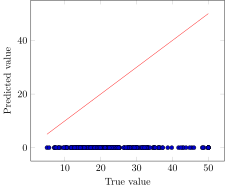

In [12]:
# Plot true values versus predicted values for epsilon-SVR on training set
epsilonsvr_svmreg_plot_training = PredictMD.plotsinglelabelregressiontrueversuspredicted(
    epsilonsvr_svmreg,
    trainingfeaturesdf,
    traininglabelsdf,
    labelname,
    )

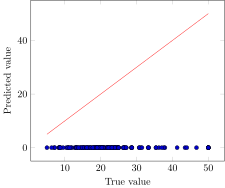

In [13]:
# Plot true values versus predicted values for epsilon-SVR on testing set
epsilonsvr_svmreg_plot_testing = PredictMD.plotsinglelabelregressiontrueversuspredicted(
    epsilonsvr_svmreg,
    testingfeaturesdf,
    testinglabelsdf,
    labelname,
    )

In [14]:
# Evaluate performance of epsilon-SVR on training set
PredictMD.singlelabelregressionmetrics(
    epsilonsvr_svmreg,
    trainingfeaturesdf,
    traininglabelsdf,
    labelname,
    )

,metric,SVM (epsilon-SVR)
1,R^2 (coefficient of determination),-6.30321


In [15]:
# Evaluate performance of epsilon-SVR on testing set
PredictMD.singlelabelregressionmetrics(
    epsilonsvr_svmreg,
    testingfeaturesdf,
    testinglabelsdf,
    labelname,
    )

,metric,SVM (epsilon-SVR)
1,R^2 (coefficient of determination),-5.42347


### Support vector machine ($\nu$-support vector regression)

In [16]:
# Set up nu-SVR model
nusvr_svmreg = PredictMD.singlelabeldataframesvmregression(
    featurenames,
    labelname;
    package = :LIBSVMjl,
    svmtype = LIBSVM.NuSVR,
    name = "SVM (nu-SVR)",
    kernel = LIBSVM.Kernel.Linear,
    verbose = false,
    )

if load_pretrained
    PredictMD.load!(nusvr_svmreg_filename, nusvr_svmreg)
else
    # set feature contrasts
    PredictMD.setfeaturecontrasts!(nusvr_svmreg, featurecontrasts)
    # Train nu-SVR model
    PredictMD.fit!(nusvr_svmreg,trainingfeaturesdf,traininglabelsdf,)
end

INFO: Starting to train LIBSVM.jl model.
INFO: Finished training LIBSVM.jl model.


PredictMD.MutableLIBSVMjlSVMEstimator("SVM (nu-SVR)", false, true, Float64[], Dict{Any,Any}(Pair{Any,Any}(:gamma, 0.1),Pair{Any,Any}(:svmtype, LIBSVM.NuSVR),Pair{Any,Any}(:degree, 3),Pair{Any,Any}(:tolerance, 0.001),Pair{Any,Any}(:nu, 0.5),Pair{Any,Any}(:cachesize, 100.0),Pair{Any,Any}(:epsilon, 0.1),Pair{Any,Any}(:kernel, Linear),Pair{Any,Any}(:verbose, false),Pair{Any,Any}(:cost, 1.0)…), LIBSVM.SVM{Float64}(LIBSVM.NuSVR, Linear::LIBSVM.Kernel.KERNEL = 0, nothing, 13, 2, Float64[], Int32[], Float64[], Int32[], LIBSVM.SupportVectors{Union{Float64, Missings.Missing},Float64}(0, Int32[], Union{Float64, Missings.Missing}[], Array{Float64}(13,0), Int32[], LIBSVM.SVMNode[]), 0.0, Array{Float64}(0,1), Float64[], Float64[], [0.0], 3, 0.1, 100.0, 0.001, 1.0, 0.5, 0.1, true, false))

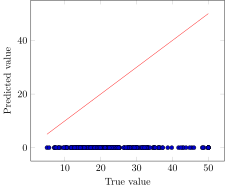

In [17]:
# Plot true values versus predicted values for nu-SVR on training set
nusvr_svmreg_plot_training = PredictMD.plotsinglelabelregressiontrueversuspredicted(
    nusvr_svmreg,
    trainingfeaturesdf,
    traininglabelsdf,
    labelname,
    )

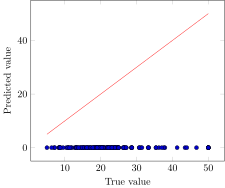

In [18]:
# Plot true values versus predicted values for nu-SVR on testing set
nusvr_svmreg_plot_testing = PredictMD.plotsinglelabelregressiontrueversuspredicted(
    nusvr_svmreg,
    testingfeaturesdf,
    testinglabelsdf,
    labelname,
    )

In [19]:
# Evaluate performance of nu-SVR on training set
PredictMD.singlelabelregressionmetrics(
    nusvr_svmreg,
    trainingfeaturesdf,
    traininglabelsdf,
    labelname,
    )

,metric,SVM (nu-SVR)
1,R^2 (coefficient of determination),-6.30321


In [20]:
# Evaluate performance of nu-SVR on testing set
PredictMD.singlelabelregressionmetrics(
    nusvr_svmreg,
    testingfeaturesdf,
    testinglabelsdf,
    labelname,
    )

,metric,SVM (nu-SVR)
1,R^2 (coefficient of determination),-5.42347


### Section 4: Save trained models to file (if desired) 

In [21]:
if save_trained
    PredictMD.save(epsilonsvr_svmreg_filename, epsilonsvr_svmreg)
    PredictMD.save(nusvr_svmreg_filename, nusvr_svmreg)
end

INFO: Saved model to file ./epsilonsvr_svmreg.jld2
INFO: Saved model to file ./nusvr_svmreg.jld2


### Appendix A: Directly access the output of regression models 

In [22]:
# We can use the PredictMD.predict() function to get the real-valued predictions
# output by each of regression models.

# Get real-valued predictions from each model for training set
PredictMD.predict(epsilonsvr_svmreg,trainingfeaturesdf)
PredictMD.predict(nusvr_svmreg,trainingfeaturesdf)

# Get real-valued predictions from each model for testing set
PredictMD.predict(epsilonsvr_svmreg,testingfeaturesdf)
PredictMD.predict(nusvr_svmreg,testingfeaturesdf)

,MedV
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0
10,0.0
